# Table of Contents
1. [Imports](#Imports)
2. [Setup of Initial Variables](#setup_init_variables)
3. [Get Bitcoin Logo](#get_btc_logo)
4. [Utility Functions for Data Preprocessing](#util_data_preprocess)
5. [Download Data Sets](#download_datasets)
    - [Extraction of Blockchain Data](#blockchain_data)
    - [Extraction of Macroeconomic Data](#macroecon_data)
    - [Extraction of Exchange Data](#exchange_data)<br><br>
     - [Vizualize Exchange Data](#price_vizualization)
     - [Preprocess Exchange Data](#preprocess_exch_data)
     - [Plot Histogram of Daily Price Changes](#hist_daily_price_ch)<br><br>
    - [Extraction of Global Currencies Exchange Data](#global_curr_exch_data)
    - [Extraction of Sentiment Data](#sentiment_data)<br><br>
7. [Merge of All Data Source](#merge_data_source)
8. [Min-Max Scaling (a.k.a Normalization)](#normalization)
9. [Statistic of Data Prior Training](#statistics)
    - [Visualize the Whole Dataset](#viz_dataset)
    - [Looking for Trends](#sesonality_differentiation)
    - [Pearson Correlation](#pearson_corr)<br><br>
10. [ML Pipeline](#ml_pipeline)
   - [Split Data (Testing, Training Data Sets)](#split_data)
   - [Set Window Length and metrics](#win_len_metrics)
   - [Fill Training, Test Data](#fill_training_test)
   - [Load Model](#load_model)
   - [Train Model](#train_model)
   - [Graph Predicted Values with Training Set](#graph_pred_training_set)
   - [Graph Predicted Values with Test Data](#graph_pred_test_set)

### <a name="imports"></a>Imports

In [90]:
from cryptory import Cryptory
import quandl
import time
import datetime

### <a name="setup_init_variables"></a>Setup Initial Variables

In [91]:
from_date="2013-04-28"
to_date=datetime.date.today().strftime("%Y-%m-%d")
my_cryptory = Cryptory(from_date=from_date)
quandl.ApiConfig.api_key = "eJns-j8GmckFnApoFoAE"
split_date = '2018-01-01' 

### <a name="get_btc_logo"></a> Get Bitcoin Logo

In [92]:
import sys
from PIL import Image
import io

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

### <a name="util_data_preprocess"></a> Utility Functions for Data Preprocessing

In [93]:
import seaborn as sns
from cryptory import Cryptory
import datetime
import matplotlib.pyplot as plt
import urllib2 as urllib
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import numpy as np

"""
    Function to make data from blockchain or other sources consistent with btc exchange data
    If data from APIs has data since 2009 we omit those, if no data exist of a date, the previous date value is used
"""
def drop_initial_rows(api, new_col_name, start_date='2013-04-28'):
    # Read data 
    api_range_format= api
    data = pd.read_csv(urllib.urlopen(api_range_format))
    
    # Check if its the Block Size data
    if 'avg' in api:
        # Format columns
        data = pd.DataFrame(data.values, columns=['date', new_col_name])
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data['date'] = pd.DataFrame(data=data['date'], columns=['date'])

        data['date'] = pd.to_datetime(data['date'])

        # Add dates that do not appear at all, because their blocksize was same as the day before
        data = data.set_index('date').resample('D').ffill()

        # Reset index
        data.index.name='date'
        data = data.reset_index()
        data = data

        # Drop values before 2013, to be consistent with BTC Exchange dataset
        data = data.drop(data[data['date'] < '2013-04-28'].index)
        data = data.reset_index(drop=True)
        return data
        
    else:
        # Get the average block size from blockchain.info; max size ==> 1 MB (by design)
        df = data
        df = pd.DataFrame(df.values, columns=['date', new_col_name])
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df['date'] = pd.DataFrame(data=df['date'], columns=['date'])
        df['date']=df
        df['date'] = pd.to_datetime(df['date'])
        # Remove rows corresponding to dates before 2013-05-02
        df = df.set_index('date').resample('D').ffill()
        df.index.name='date'
        df.index.names = ['date']
        data = df.reset_index()
        df = data
        df[df['date'] < start_date]

        df = df.drop(df[df['date'] < start_date].index)
        df = df.reset_index(drop=True)
        return df

In [94]:
def rename_columns(prepend_to_name, df):
    df.columns = [df.columns[0]]+ \
                [str(prepend_to_name)+i for i in df.columns[1:]]

### <a name="download_datasets"></a> Download Data Sets

#### <a name="blockchain_data"></a> Extraction of Blockchain Data

In [95]:
# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
block_size_api = "https://blockchain.info/charts/avg-block-size?timespan=all&format=csv" 
avg_block_size = drop_initial_rows(block_size_api, 'avg_block_size')

# Get transactions Daily
txs_api = "https://api.blockchain.info/charts/n-transactions?timespan=all&format=csv" 
txs_data = drop_initial_rows(txs_api, 'transactions')

## Data From Blockchain.info through Quandl API: https://www.quandl.com/data/BCHAIN-Blockchain

# Bitcoin Mining Difficulty
bchain_diff_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/DIFF.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_diff_data = drop_initial_rows(bchain_diff_api, 'difficulty')

# Bitcoin api.blockchain Size
bchain_blchs_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/BLCHS.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_blchs_data = drop_initial_rows(bchain_blchs_api, 'bchain_size')

# Rvenue of Bitcoin Miners
bchain_mirev_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/MIREV.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_mirev_data = drop_initial_rows(bchain_mirev_api, "mining_revenue")

# Bitcoin Hashhttp://localhost:8888/notebooks/Data%20Gathering.ipynb# Rate
bchain_hash_rate_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/CPTRA.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_hash_rate_data = drop_initial_rows(bchain_hash_rate_api, "hash_rate")
                       
# Bitcoin Cost Per Transaction
bchain_cpt_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/NADDU.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_cpt_data = drop_initial_rows(bchain_cpt_api, "cost_per_transaction")   

blockchain_data = avg_block_size.merge(txs_data, on='date', how='inner'). \
            merge(bchain_diff_data,on='date' ,how='inner'). \
            merge(bchain_blchs_data, on='date', how='inner'). \
            merge(bchain_mirev_data, on='date', how='inner'). \
            merge(bchain_hash_rate_data, on='date', how='inner'). \
            merge(bchain_cpt_data, on='date', how='inner')


In [96]:
# Gist of it
blockchain_data.head()

,date,avg_block_size,transactions,difficulty,bchain_size,mining_revenue,hash_rate,cost_per_transaction
0,2013-04-28,0.126539,40986,8.9743e+06,6820,572110,13.9587,107554
1,2013-04-29,0.126539,40986,8.9743e+06,6844,645240,12.9025,73687
2,2013-04-30,0.185539,48795,1.00763e+07,6870,525693,10.7735,60887
3,2013-05-01,0.185539,48795,1.00763e+07,6892,442507,8.77347,61672
4,2013-05-02,0.189949,57278,1.00763e+07,6918,383775,6.70022,67744


#### <a name="macroecon_data"></a>Extraction of Macroeconomic Data

In [97]:
# S&P 500
s_and_p_stock = my_cryptory.get_stock_prices(market="%5EGSPC")
s_and_p_stock = s_and_p_stock.loc[:,['date', 'close']]
# Rename close column
s_and_p_stock = s_and_p_stock.rename(columns={'close': 'sp_close'})


# Dow and Jones
dow_jones_stock = my_cryptory.get_stock_prices(market="%5EDJI")
dow_jones_stock = dow_jones_stock.loc[:,['date', 'close']]
dow_jones_stock = dow_jones_stock.rename(columns={'close': 'dj_close'})


# Nasdaq
nasdaq_stock = my_cryptory.get_stock_prices(market="%5EIXIC")
nasdaq_stock = nasdaq_stock.loc[:,['date', 'close']]
nasdaq_stock = nasdaq_stock.rename(columns={'close': 'nasdaq_close'})

# Vix
vix_stock = my_cryptory.get_stock_prices(market="%5EVIX")
vix_stock = vix_stock.loc[:,['date', 'close']]
vix_stock = vix_stock.rename(columns={'close': 'vix_close'})

# Commodity Prices
metals_prices = my_cryptory.get_metal_prices()
metals_prices = metals_prices[['date', 'gold_am', 'silver']]

# Oil Price
oil_price = my_cryptory.get_oil_prices()

macro_econ_data = s_and_p_stock.merge(dow_jones_stock,on='date', how='inner') \
                .merge(nasdaq_stock,on='date', how='inner') \
                .merge(vix_stock, on='date', how='inner') \
                .merge(metals_prices,on='date', how='inner') \
                .merge(oil_price, on='date', how='inner')


In [98]:
# Gist of it
macro_econ_data.head() 

,date,sp_close,dj_close,nasdaq_close,vix_close,gold_am,silver,oil_price
0,2018-09-19,2907.949951,26405.759766,7950.037598,11.79,1199.4,14.210,68.86
1,2018-09-18,2904.310059,26246.960938,7956.109863,12.79,1199.4,14.210,68.86
2,2018-09-17,2888.800049,26062.119141,7895.790039,13.68,1196.8,14.170,68.86
3,2018-09-16,2904.979980,26154.669922,8010.040039,12.07,1206.2,14.215,68.98
4,2018-09-15,2904.979980,26154.669922,8010.040039,12.07,1206.2,14.215,68.98


#### <a name="exchange_data"></a> Extraction of Exchange Data

In [99]:
# Daily data from coinmarketcap
coinmarket_btc_market_info = my_cryptory.extract_coinmarketcap("bitcoin")

##### <a name="price_vizualization"></a>Vizualize Exchange Data

[]

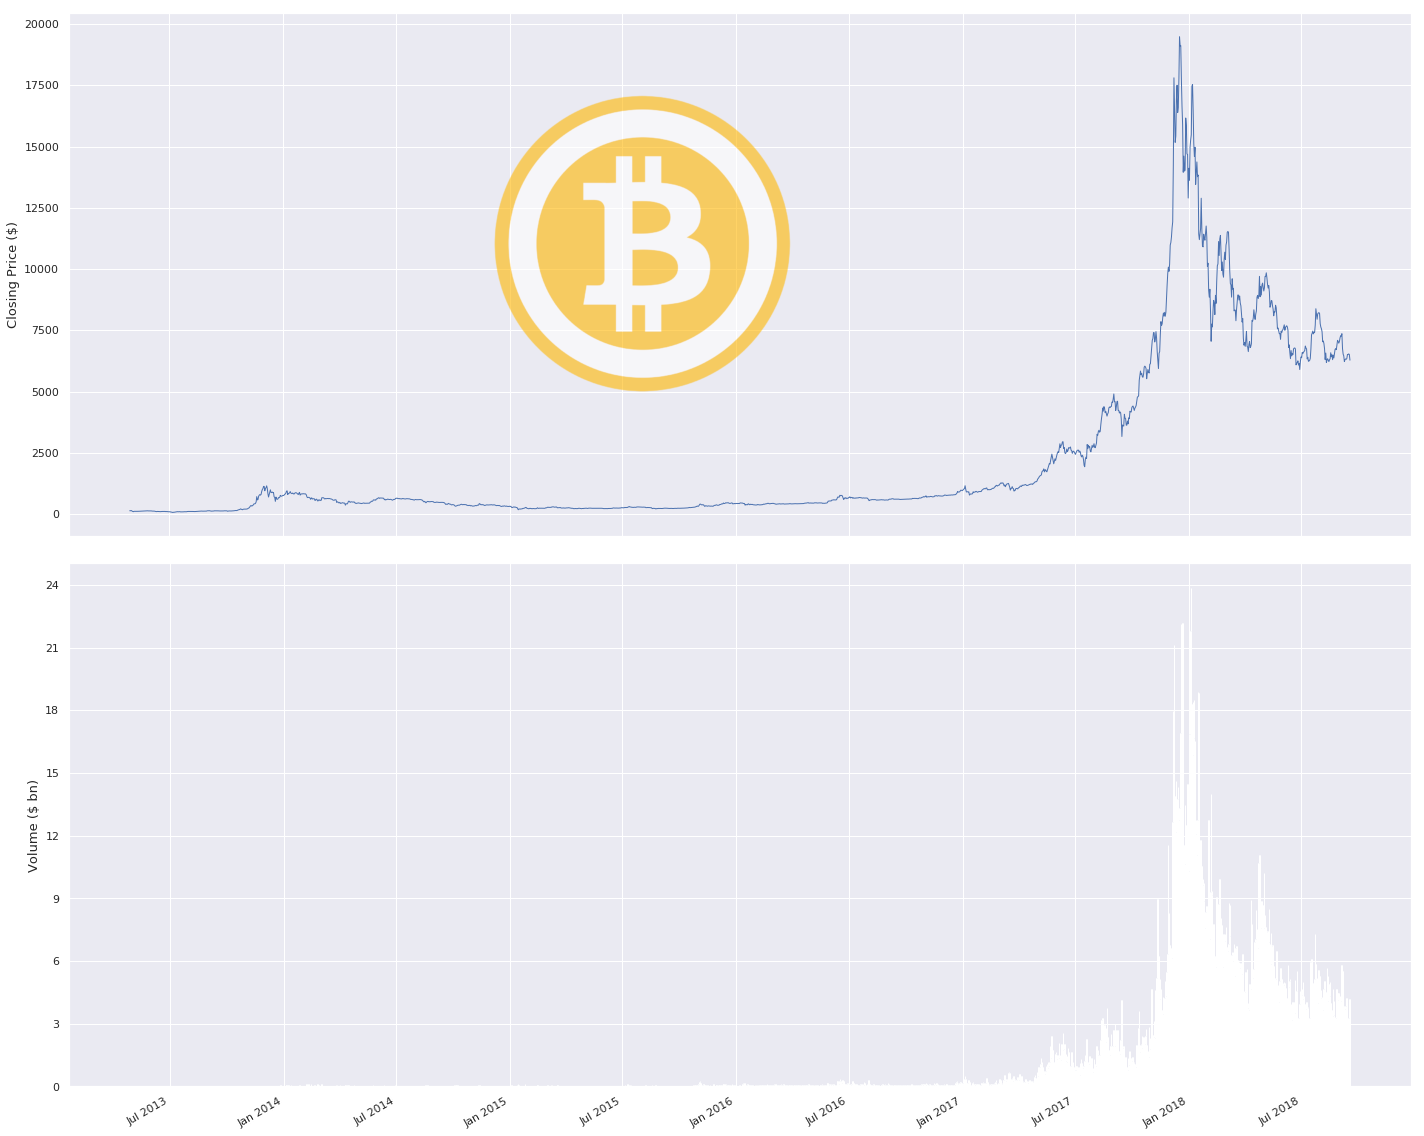

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 14
# rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 5]} )
fig.autofmt_xdate()

ax1.set_ylabel('Closing Price ($)',fontsize=13)
ax2.set_ylabel('Volume ($ bn)',fontsize=13)
ax2.set_yticks([int('%d000000000'%i) for i in range(0, 25, 3)])
ax2.set_yticklabels(range(0, 25, 3))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(coinmarket_btc_market_info['date'].astype(datetime.datetime),coinmarket_btc_market_info['open'])
ax2.bar(coinmarket_btc_market_info['date'].astype(datetime.datetime).values, coinmarket_btc_market_info['volume'].values)
fig.tight_layout()

fig.figimage(bitcoin_im, 320, 650, zorder=3, alpha=.6)
plt.plot(subplots=True)
# plt.show()

##### <a name="preprocess_exch_data"></a>Preprocess Exchange Data

In [61]:
############################################################################################
#######
####### Add New Columns
#######
############################################################################################
btc_market_info = my_cryptory.extract_coinmarketcap('bitcoin')
btc_market_info = coinmarket_btc_market_info.assign(Date=pd.to_datetime(btc_market_info['date']))
pd.DataFrame(btc_market_info).fillna(btc_market_info.mean())
# Housekeeping
btc_market_info['volume'] = btc_market_info['volume'].astype('int64')
btc_market_info.columns = btc_market_info.columns.str.replace("*", "") 
btc_market_info = btc_market_info.assign(Date=pd.to_datetime(btc_market_info['date'])) 
rename_columns('bt_', btc_market_info)

# Calculate new columns
for coins in ['bt_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'close']-x[coins+'open'])/x[coins+'open']}
    btc_market_info = btc_market_info.assign(**kwargs)

for coins in ['bt_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'high']- x[coins+'close'])/(x[coins+'high']-x[coins+'low'])-1,
            coins+'volatility': lambda x: (x[coins+'high']- x[coins+'low'])/(x[coins+'open'])}
    btc_market_info = btc_market_info.assign(**kwargs)

##### <a name="hist_daily_price_ch"></a>Plot Histogram of Daily Price Changes

Text(0.5,1,'Bitcoin Daily Price Changes')

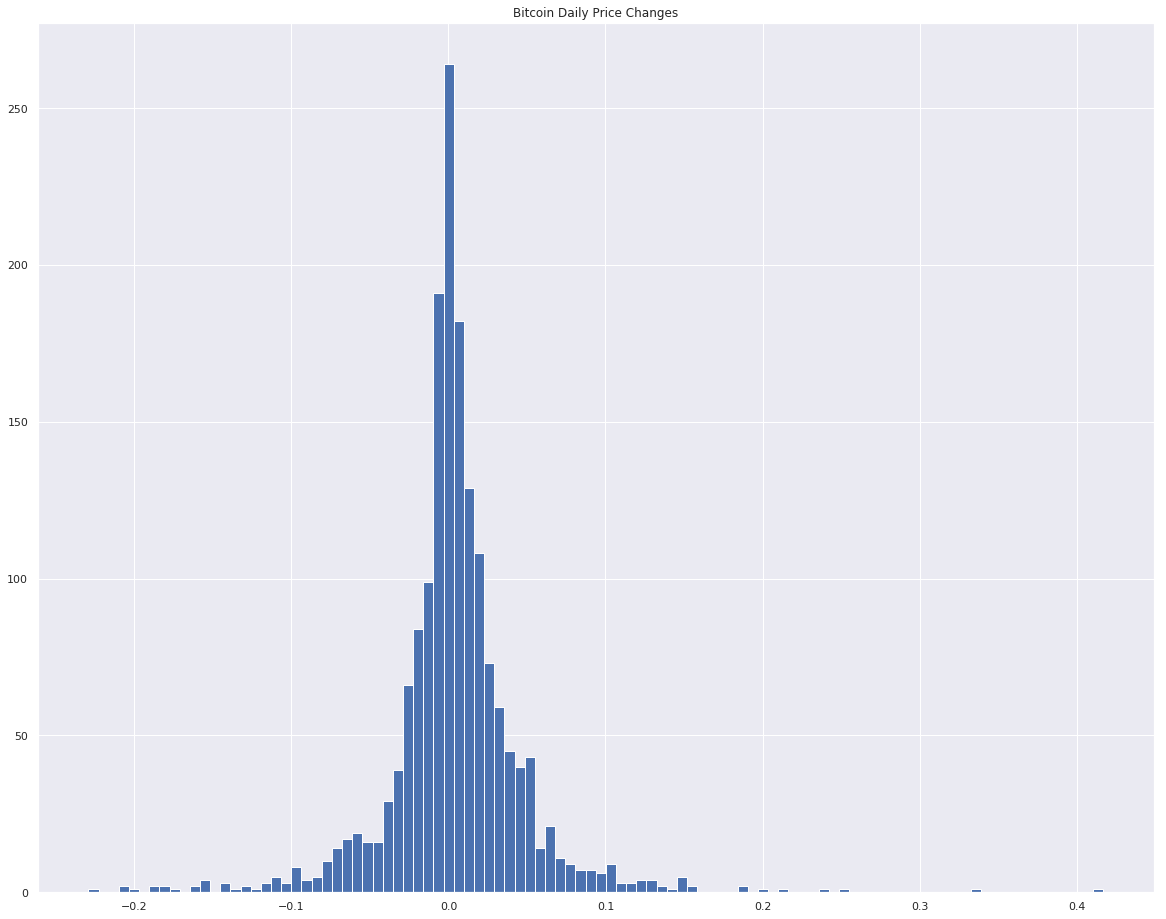

In [62]:
fig, ax1 = plt.subplots()
ax1.hist(btc_market_info[btc_market_info['date']< split_date]['bt_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')

#### <a name="global_curr_exch_data"></a> Global Currencies Exchange Data

In [63]:
# USD - EUR
eur_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")
eur_usd_exchange_rate = eur_usd_exchange_rate.rename(columns={'exch_rate': 'eur_exch_rate'})

# USD - JPY
jpy_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="JPY")
jpy_usd_exchange_rate = jpy_usd_exchange_rate.rename(columns={'exch_rate': 'jpy_exch_rate'})

# USD - Yuan
cny_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="CNY")
cny_usd_exchange_rate = cny_usd_exchange_rate.rename(columns={'exch_rate': 'cny_exch_rate'})


exchange_data = btc_market_info.merge(eur_usd_exchange_rate, on='date', how='inner'). \
            merge(jpy_usd_exchange_rate,on='date' ,how='inner'). \
            merge(cny_usd_exchange_rate, on='date', how='inner')

# Get Rid of data that was included in new columns
exchange_data = exchange_data[['date','eur_exch_rate','jpy_exch_rate','cny_exch_rate']+[coin+metric for coin in ['bt_'] 
                                   for metric in ['close','volume','close_off_high','volatility']]]

In [64]:
exchange_data.head()

,date,eur_exch_rate,jpy_exch_rate,cny_exch_rate,bt_close,bt_volume,bt_close_off_high,bt_volatility
0,2018-09-18,1.1697,0.009147,0.157811,6371.30,4180090000,-0.782561,0.018862
1,2018-09-17,1.1671,0.009147,0.157811,6281.20,3910780000,0.832467,0.043397
2,2018-09-16,1.1689,0.009147,0.157811,6517.18,3273730000,-0.355337,0.012886
3,2018-09-15,1.1689,0.009147,0.157811,6543.20,3216300000,-0.456652,0.010473
4,2018-09-14,1.1689,0.009147,0.157811,6512.71,4076220000,0.191882,0.021477


#### <a name="sentiment_data"></a>Extraction of Sentiment Data

In [65]:
####################################################################################################################
########
######## Extract Sentiment Data
########
####################################################################################################################
btc_google_trends = my_cryptory.get_google_trends(kw_list=['bitcoin'])
rename_columns('google_trends_', btc_google_trends)

btc_google_trends.head()
# # Leave our reddit for now
# btc_reddit_subscribers = my_cryptory.extract_reddit_metrics(subreddit="bitcoin", 
#                                          metric="total-subscribers")
# rename_columns('reddit_', btc_reddit_subscribers)

,date,google_trends_bitcoin
0,2018-09-17,5.710604
1,2018-09-16,4.568483
2,2018-09-15,5.139543
3,2018-09-14,5.710604
4,2018-09-13,6.281664


### <a name="merge_data_source"></a>Merge of All Data Source

In [68]:
btc_final = exchange_data.merge(btc_google_trends, on='date', how='inner'). \
            merge(blockchain_data,on='date' ,how='inner'). \
            merge(macro_econ_data, on='date', how='inner')

arr = btc_final.columns.values

In [69]:
# need to reverse the data frame so that subsequent rows represent later timepoints
btc_final = btc_final.sort_values(by='date')

### <a name="normalization"></a>Min-Max Scaling (a.k.a Normalization)

In [70]:
# NORMALIZE USING MIN-MAX METHOD INSTEAD OF STANDARDIZATION
from sklearn.preprocessing import minmax_scale
import numpy as np
from sklearn.preprocessing import Imputer

mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

btc_without_date = btc_final.loc[:, btc_final.columns != 'date']

# Train the imputor on the df dataset
mean_imputer = mean_imputer.fit(btc_without_date)

# Apply the imputer to the df dataset
imputed_df = mean_imputer.transform(btc_without_date)

# Get back columns
imputed_df = pd.DataFrame(imputed_df, columns = btc_without_date.columns)

# # From numpy array to numpy list
# all_columns_list = btc_final.columns.values.tolist()

imputed_df[['eur_exch_rate', 'jpy_exch_rate', 'cny_exch_rate', 'bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'bchain_size', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close', 'dj_close', 'nasdaq_close', 'vix_close', 'gold_am', 'silver', 'oil_price']] = \
        minmax_scale(imputed_df[['eur_exch_rate', 'jpy_exch_rate', 'cny_exch_rate', 'bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'bchain_size', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close', 'dj_close', 'nasdaq_close', 'vix_close', 'gold_am', 'silver', 'oil_price']])

# Re add date column
imputed_df['date'] = btc_final['date']

# Order by date
imputed_df["date"] = imputed_df["date"].values[::-1]

btc_final=imputed_df

In [71]:
# Get rid of rows where volume is 0
btc_final = btc_final[btc_final['bt_volume']!=0]
# Reindex, starting from 0 
btc_final.index = range(len(btc_final))

In [72]:
btc_final.to_csv('btc_final.csv')

### <a name="statistics"></a>Statistic of Data Prior Training

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

#### <a name="viz_dataset"></a> Visualize the Whole Dataset

/home/kejsi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


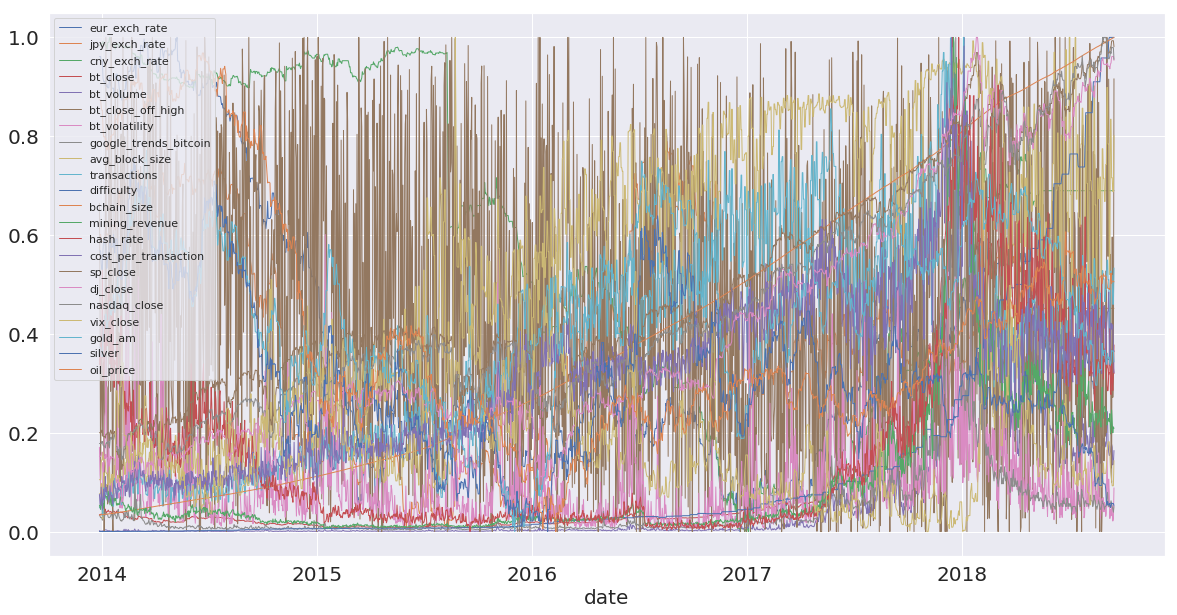

In [74]:
test = btc_final.copy()
test.date_index = pd.to_datetime(test['date'])
test.set_index('date', inplace=True)
test.plot(figsize=(20,10), linewidth=1, fontsize=20)
plt.xlabel('date', fontsize=20);

#### <a name="sesonality_differentiation"></a>Looking for Trends

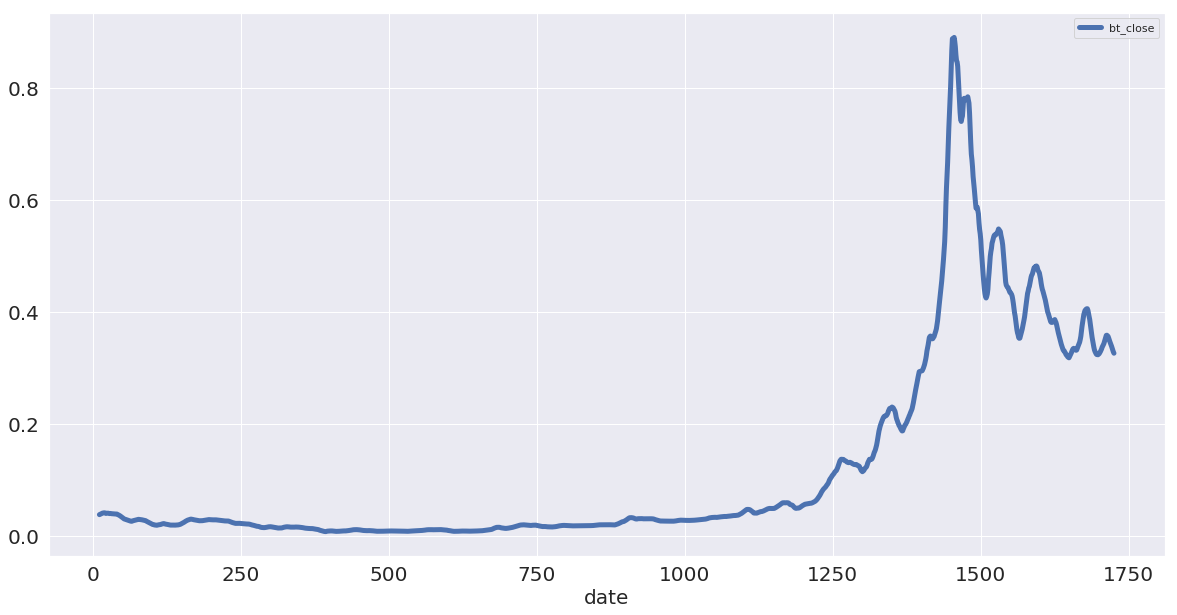

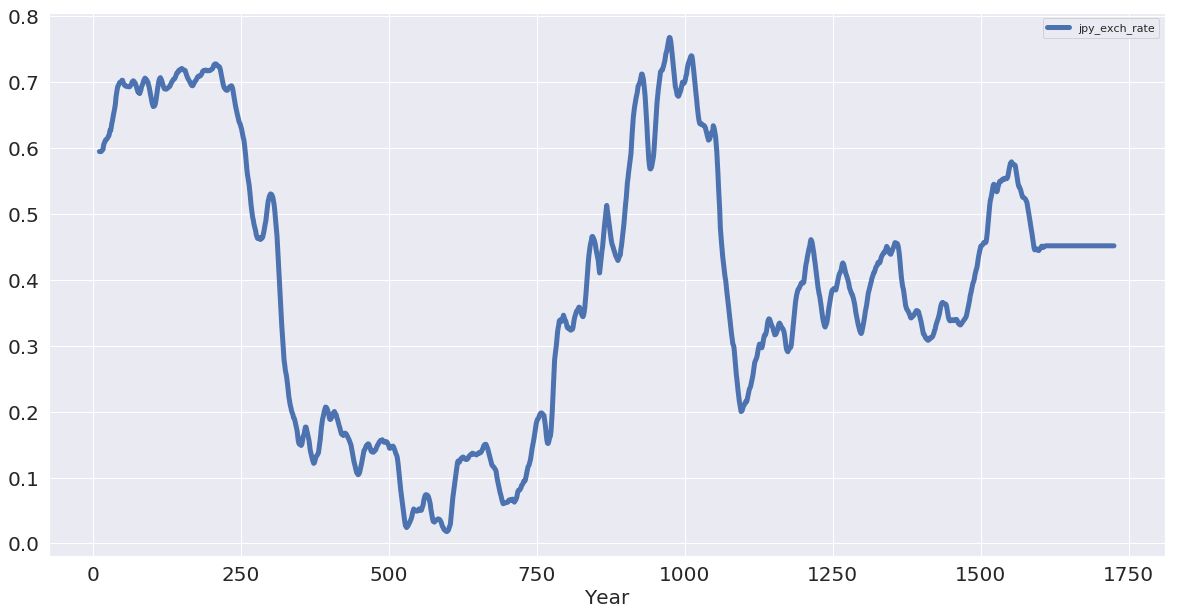

In [75]:
# Trying to get out of the graph up, we check for seasonality
btc_close_price = btc_final[['bt_close']]
btc_close_price.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('date', fontsize=20);

yen = btc_final[['jpy_exch_rate']]
yen.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

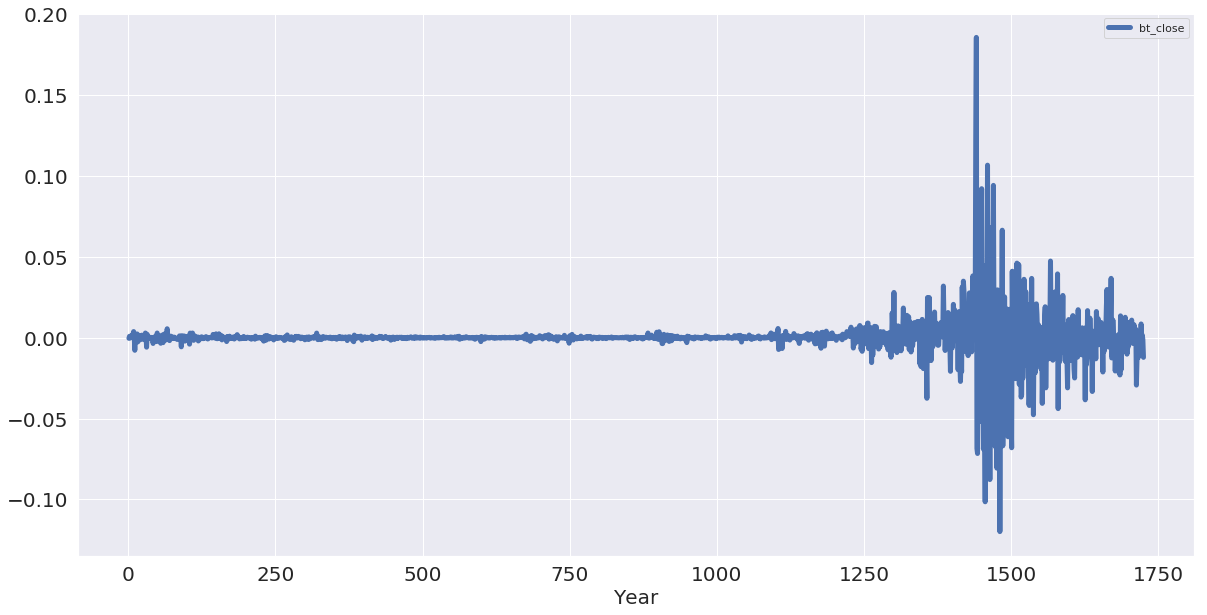

In [76]:
# First Order Differencing
btc_close_price.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
"""
    Removing the trends seems almost atrocious; The bubbles are very apparent
"""
plt.xlabel('Year', fontsize=20);

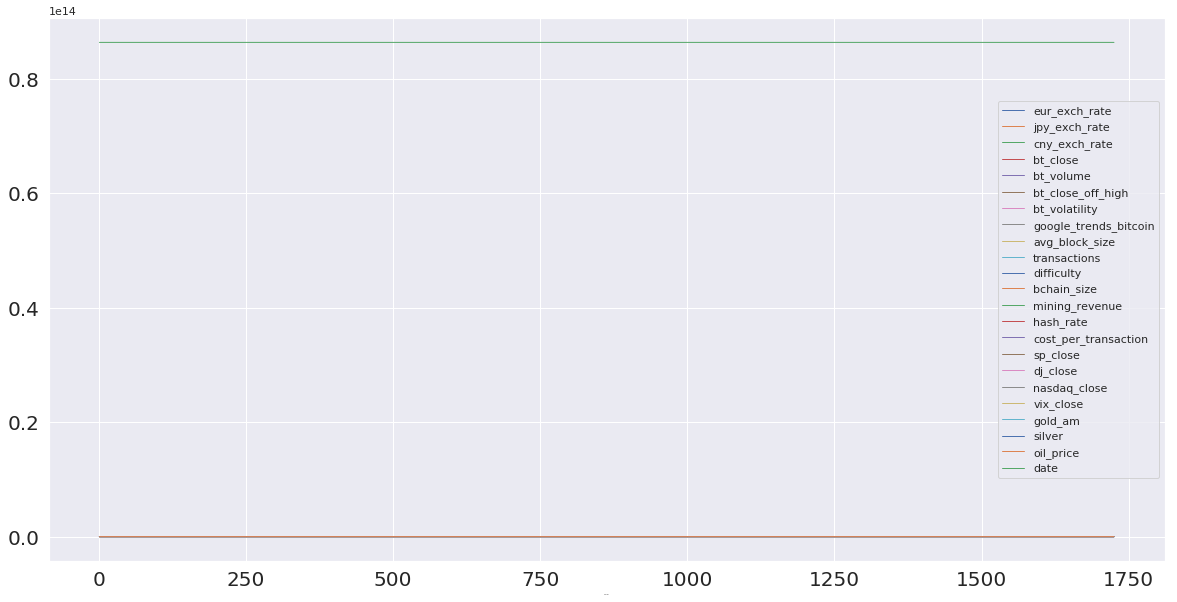

In [77]:
btc_final.diff().plot(figsize=(20,10), linewidth=1, fontsize=20)
plt.xlabel('Year', fontsize=2);

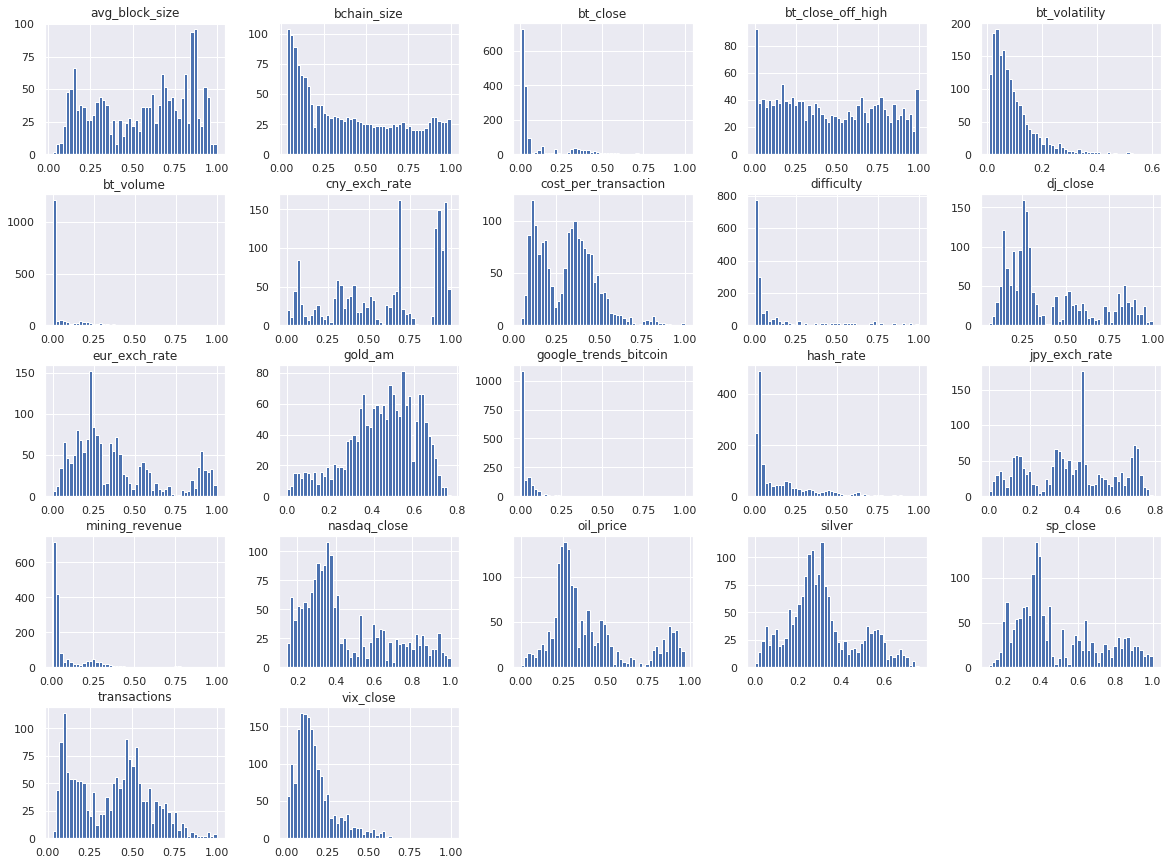

In [78]:
btc_final.hist(bins=50, figsize=(20,15))
# print(all_coins_df)
plt.show()

#### <a name="pearson_corr"></a> Pearson Correlation

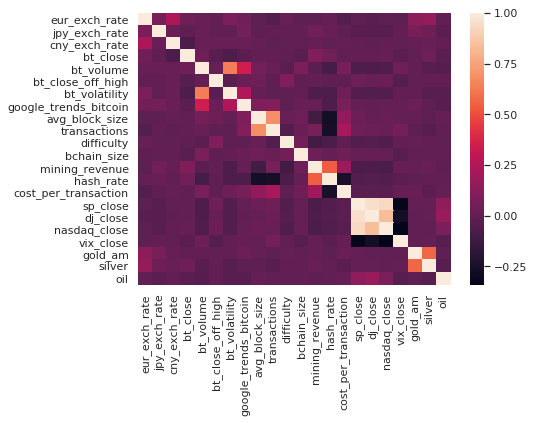

,eur_exch_rate,jpy_exch_rate,cny_exch_rate,bt_close,bt_volume,bt_close_off_high,bt_volatility,google_trends_bitcoin,avg_block_size,transactions,difficulty,bchain_size,mining_revenue,hash_rate,cost_per_transaction,sp_close,dj_close,nasdaq_close,vix_close,gold_am,silver,oil_price
eur_exch_rate,1,0.072,0.24,0.035,0.026,0.0052,0.075,0.049,-0.011,-0.046,0.018,-0.0079,-0.012,0.015,-0.046,-0.015,-0.026,-0.014,-0.014,0.13,0.16,-0.0012
jpy_exch_rate,0.072,1,0.025,-0.0073,0.019,0.00055,-0.0034,0.053,-0.0057,0.0047,-0.0049,-0.0015,0.052,0.025,-0.0051,-0.033,-0.026,-0.028,0.0045,0.07,0.037,-0.021
cny_exch_rate,0.24,0.025,1,-0.072,0.016,0.02,0.017,0.022,0.0083,-0.012,-0.004,-0.0047,0.012,-0.0044,0.0056,-0.0037,-0.0054,0.0022,-0.0047,0.014,0.017,0.0023
bt_close,0.035,-0.0073,-0.072,1,0.041,-0.032,-0.066,-0.019,0.0048,0.00097,-0.0075,-0.025,0.096,0.047,-0.0024,0.0039,0.0013,0.012,-0.021,-2.1e-05,0.037,-0.025
bt_volume,0.026,0.019,0.016,0.041,1,0.0082,0.64,0.34,0.053,0.021,-0.019,0.081,-0.023,-0.091,0.071,-0.063,-0.064,-0.06,0.038,0.0017,-0.031,-0.037
bt_close_off_high,0.0052,0.00055,0.02,-0.032,0.0082,1,-0.024,0.03,0.032,-0.0063,0.099,-0.0075,-0.0032,-0.0063,-0.0069,0.032,0.021,0.03,-0.046,-0.00077,2.9e-05,0.0054
bt_volatility,0.075,-0.0034,0.017,-0.066,0.64,-0.024,1,0.24,0.0084,-0.013,-0.013,0.00098,-0.064,-0.064,0.037,-0.049,-0.053,-0.052,0.0049,0.00089,-0.035,-0.026
google_trends_bitcoin,0.049,0.053,0.022,-0.019,0.34,0.03,0.24,1,0.094,0.1,-0.013,0.022,0.013,-0.066,0.069,0.0068,0.0016,0.0059,0.016,0.028,-0.012,-0.03
avg_block_size,-0.011,-0.0057,0.0083,0.0048,0.053,0.032,0.0084,0.094,1,0.69,0.016,0.037,-0.1,-0.27,0.15,0.027,0.012,0.024,0.0059,0.0067,-0.0058,0.012
transactions,-0.046,0.0047,-0.012,0.00097,0.021,-0.0063,-0.013,0.1,0.69,1,-0.048,0.024,0.065,-0.26,0.22,0.032,0.027,0.018,0.055,-0.012,-0.029,-0.0042


In [79]:
# Pearson correlation on all attributes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# date column not need for upcoming calculations
all_features_df = btc_final.drop('date', axis=1)
# Percentage change => 
# first calculate: Increase = y_t - y_(t-1) then calculate: %Increace = (Increase-y_(t-1))*100
"""
    %Increase is used both to track the prices of individual securities and 
    of large market indexes, as well as comparing the values of different currencies.  
    Balance sheets with comparative financial statements will generally include the 
    prices of specific assets at different points in time along with the percentage 
    changes over the accompanying periods of time.  
"""
# Compute pairwise correlation of columns, excluding NA/null values
corr = all_features_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()


# Table view for readibility
# cmap=sns.diverging_palette(5, 250, as_cmap=True)
cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

### <a name="ml_pipeline"></a> ML Pipeline
#### <a name="split_data"></a> Split Data (Testing, Training Data Sets)

In [80]:
# Get rid of 'date' columns
training_set, test_set = btc_final[btc_final['date']<split_date], btc_final[btc_final['date']>=split_date]
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)

#### <a name="win_len_metrics"></a> Set Window Length and metrics

In [81]:
window_len = 10
norm_cols = ['bt_close','bt_volume']

#### <a name="fill_training_test"></a>Fill Training, Test Data

In [82]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_close'][window_len:].values/training_set['bt_close'][:-window_len].values)-1

In [83]:
print(LSTM_training_outputs)

[ 0.32734309  0.11248104  0.14434986 ... -0.1762171  -0.22181459
 -0.10464286]


In [84]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_close'][window_len:].values/test_set['bt_close'][:-window_len].values)-1
# print(LSTM_test_outputs)

In [85]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

#### <a name="load_model"></a>Load Model

In [86]:
# %load models/lstm_model.py
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras import optimizers
"""
    If network is overfitting => decrease batch size; the vice-versa for underfitting
"""
def lstm_model(inputs, output_size, neurons, optimizer="sgd", loss="mae", activ_func="relu",
                dropout=0.3): 
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#### <a name="train_model"></a>Train Model 

In [87]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

# Optmizer
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 300
# initialise model architecture
bt_model = lstm_model(LSTM_training_inputs, output_size=pred_range, neurons = 10)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_close'][i:i+pred_range].values/
                                  training_set['bt_close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 11s - loss: 0.7384
Epoch 2/50
 - 14s - loss: 0.7339
Epoch 3/50
 - 11s - loss: 0.7294
Epoch 4/50
 - 12s - loss: 0.7247
Epoch 5/50
 - 8s - loss: 0.7174
Epoch 6/50
 - 12s - loss: 0.7064
Epoch 7/50
 - 8s - loss: 0.6928
Epoch 8/50
 - 8s - loss: 0.6767
Epoch 9/50
 - 12s - loss: 0.6579
Epoch 10/50
 - 10s - loss: 0.6327
Epoch 11/50
 - 7s - loss: 0.6118
Epoch 12/50
 - 8s - loss: 0.5936
Epoch 13/50
 - 11s - loss: 0.5779
Epoch 14/50
 - 6s - loss: 0.5683
Epoch 15/50
 - 12s - loss: 0.5578
Epoch 16/50
 - 4s - loss: 0.5511
Epoch 17/50
 - 8s - loss: 0.5391
Epoch 18/50
 - 7s - loss: 0.5367
Epoch 19/50
 - 7s - loss: 0.5333
Epoch 20/50
 - 6s - loss: 0.5262
Epoch 21/50
 - 7s - loss: 0.5257
Epoch 22/50
 - 7s - loss: 0.5195
Epoch 23/50
 - 7s - loss: 0.5173
Epoch 24/50
 - 7s - loss: 0.5134
Epoch 25/50
 - 7s - loss: 0.5086
Epoch 26/50
 - 10s - loss: 0.5062
Epoch 27/50
 - 9s - loss: 0.5094
Epoch 28/50
 - 9s - loss: 0.5028
Epoch 29/50
 - 9s - loss: 0.5011
Epoch 30/50
 - 7s - loss: 0.5002
Epoch 31/

#### <a name="graph_pred_training_set"></a>Graph Predicted Values with Training Set

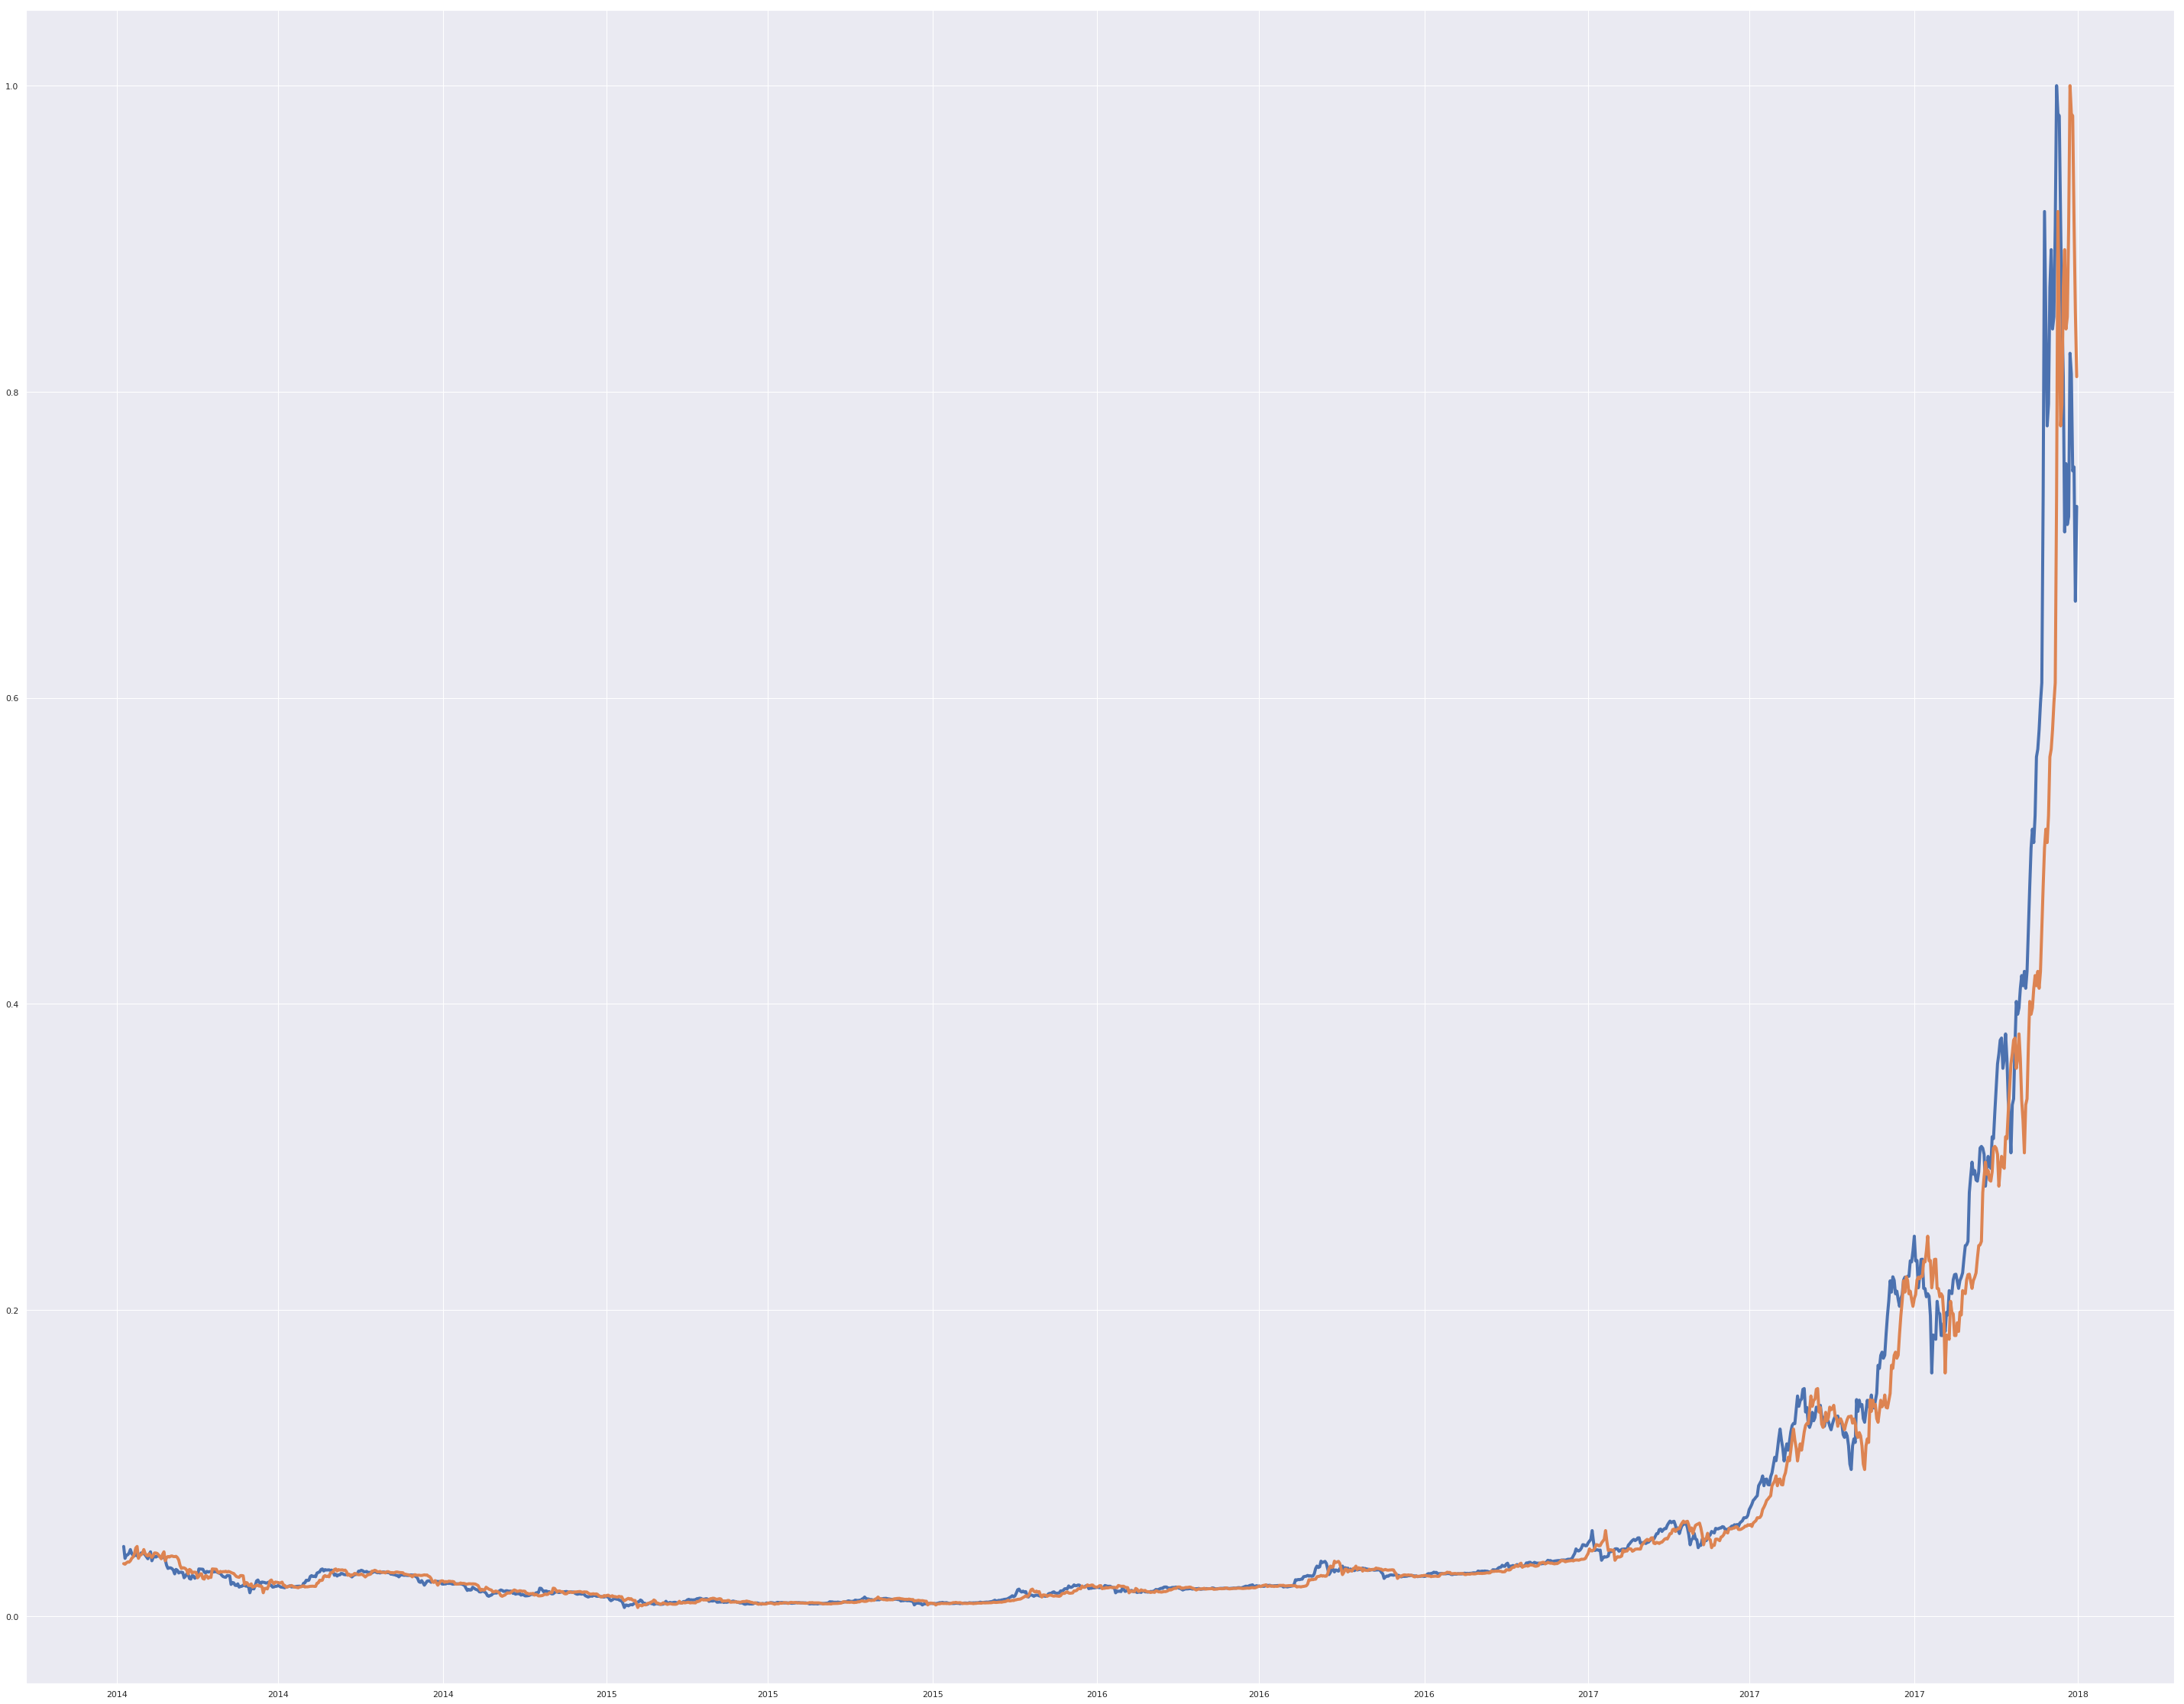

In [88]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2014,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2014,2019) for j in [1,5,9]])
ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_close'].values[window_len:])/(training_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
# axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
# axins.set_ylim([920, 1400])
# mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

#### <a name="graph_pred_test_set"></a> Graph Predicted Values with Test Data

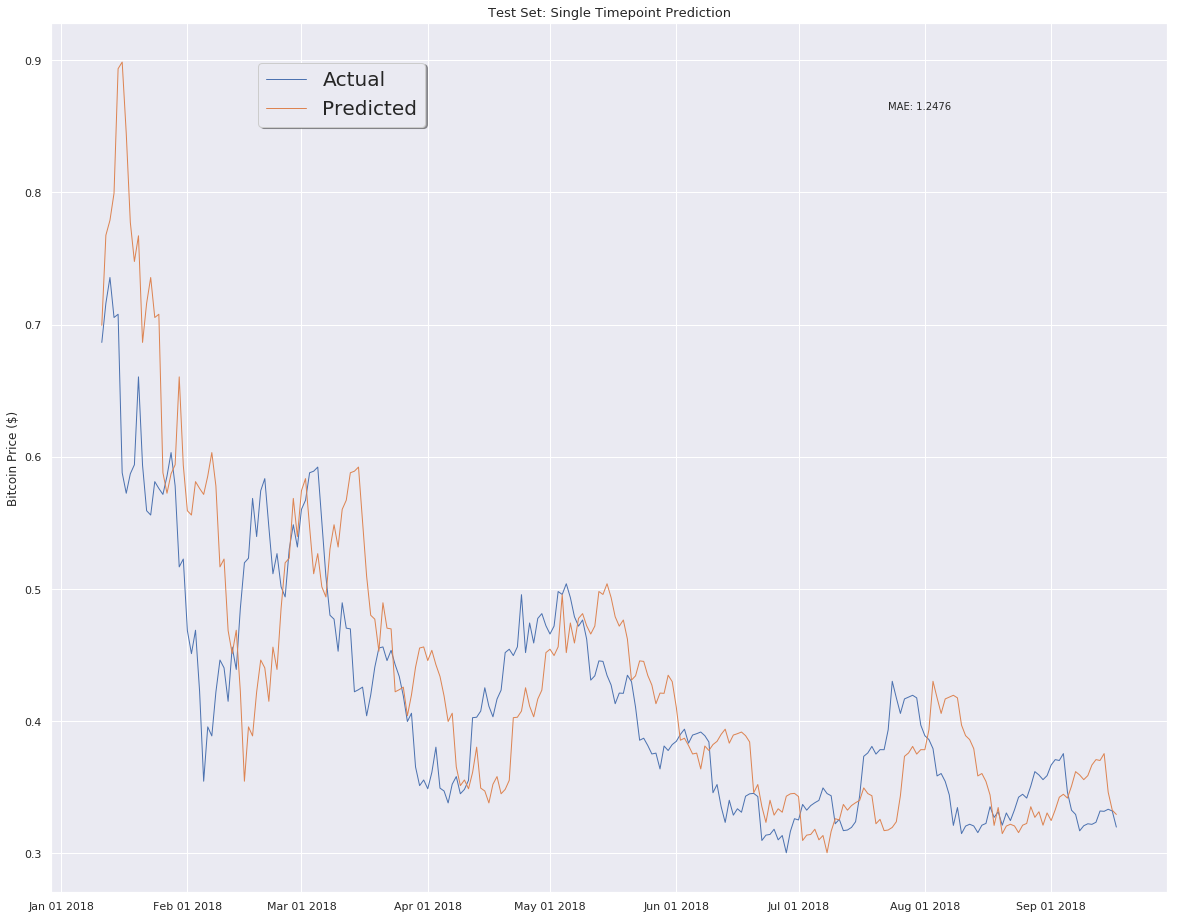

In [89]:
# %matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 1
rcParams['figure.figsize'] = (20, 16)

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['bt_close'][window_len:], label='Actual')

ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')

ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_close'].values[window_len:])/(test_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()